# Sensitivity code tutorial

This notebook is intended to demonstrate how the python-based sensitivity code works, and how one can run it. It is not intended to be used for a full calculation -- full calculations should be written up into a script and run in many parallel jobs on a cluster. Instead, this document is intended to walk you through a calculation start-to-finish, and show you what each step is doing. If there is something that is not explained well, or could be better documented, feel free to get in touch: blenardo@stanford.edu

## Definitions/glossary

There are a few words that have very specific meanings in the context of the sensitivity code.  We define them here:
* **Component:** A "component" is a specific material/isotope pair. For instance, "Field Ring U238" is a single component. Each component has an associated specific activity, mass, and PDF.
* **PDF:** This stands for "probability density function," and in our context means the distribution in energy/standoff/whatever-space for events from a certain component. PDFs are generated using the processed (clustered & reconstructed) output from the Geant4 simulations.
* **Material:** A "material" is exactly what it sounds like: copper, silicon, Al, etc. 
* **Isotope:** The parent isotope which produces the background PDF. For example, any backgrounds from the Th232 decay chain for a given material will be lumped together, and the events will all be contained in a PDF with the isotope Th232.
* **Group:** A "group" is defined as a grouping of multiple components, with a single PDF corresponding to the weighted sum of each of the component PDFs. Generally, we'd like to form groups of components with similarly-shaped distributions, to avoid degeneracies in our fits. 
* **Livetime:** Our assumption for how long the experiment will run
* **Specific Activity:** How many decays of a given isotope we will get per unit mass of the material. These values come from assay measurements.
* **Mass:** Mass of the component in kg. Used in conjunction with Specific Activity to determine the weight (meaning number of counts) of the PDF for each component. 
* **Weight:** Here, the word "weight" does not refer to a physical property, but rather a coefficient that scales the PDF to the appropriate number of counts that we expect to see in our experiment.
* **Hit Efficiency:** This isn't actually used in the sensitivity code, but is stored in the Materials Spreadsheet nonetheless; it quantifies what fraction of decays from a given component create an event in a specific energy region (e.g. the FWHM ROI) and mass (e.g. the inner two tons)



## Import relevant libraries

First, of course, we need to import the relevant libraries. The sensitivity code has several dependencies that you will need to install:
* xlrd
* uproot
* pandas
* histlite

If you need help installing these, please contact Brian L. From here, I'll assume that you've installed all of these already.

The nEXO-specific python classes are contained in the directory: 
<code>sensitivity/modules</code>
To correctly import them, you'll need to append this directory to python's search path, as below.


In [1]:
# Import sys, then tell python where to find the nEXO-specific classes

import sys
!pwd
sys.path.append('../modules')

/Users/brianlenardo/Research/nEXO/sensitivity/work


In [2]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

## OPTIONAL: Converting the Excel spreadsheet and ROOT pdfs to HDF5 file formats.

The Materials Spreadsheet is a document stored in the Materials Database, which contains relevant information of the activities, masses, and Geant4 hit efficiencies. To feed it into the sensitivity code, we need to parse the spreadsheet and turn it into a more readily machine-readable format. Here we accomplish this using a script called ```ConvertExcel2DataFrame.py``` contained in ```sensitivity/work/```. This script uses the Pandas python library to read and then store the information in the spreadsheet.

The 



# Step 1: Creating a workspace

The ```workspace``` class is a container that stores and organizes all of the various sub-objects and data tables that are required for the sensitivity calculation. These include:

* **df_components**, which is a pandas-dataframe version of the Materials Spreadsheet from the Materials Database. This contains details for every component in the detector, including specific activities and masses, as well as the Geant4-generated distributions, which we need to generate an overall event distribution.
* **df_group_pdfs**, which is a pandas dataframe containing the PDFs for each group that we'll use in the fit.
* **neg_log_likelihood**, which is the object that contains the likelihood function and a list of the free parameters in the fit.
* **minimizer**, which is the minimizer (we currently use iMinuit)
* **livetime**, a variable storing the number of seconds that we expect the experiment to run
* **histogram_axis_names**, which is a list storing the names of each dimension in the fit (e.g. "energy", "standoff", etc.)
* **config**, a dict which contains configuration parameters, read in from a YAML configuration file. Most importantly, the YAML file contains the group assignments, i.e. which group each component will be added to to generated the summed PDFs. The YAML file can also contain things like custom user-defined weights for the PDFs, if you want to play around with activities and stuff.

The ```workspace``` also has methods to populate the sub-objects.

Below, we create a workspace, then load in the input dataframe and grouped PDFs from files generated by the materials database. 


In [4]:
workspace = nEXOFitWorkspace.nEXOFitWorkspace( config = 'config/TUTORIAL_config.yaml')

If you want to change the groupings, etc, you should create a new configuration YAML file and add it here.




# Step 2: Generating or loading the components table

The "components table" is the same as "df_components" described above - it should combine the information from the Materials Database (activities, hit efficiencies, etc.) with the Geant4-generated distributions into one easily-manipulated table. 

The components table can be included in three different ways:
* Loading a previously-generated ComponentsTable file
* Generating a new ComponentsTable file using an Excel spreadsheet downloaded from the Materials DB
* Generating a new ComponentsTable file by directly reading the Materials DB (NOT YET IMPLEMENTED!!)

**All** of these options require that you have the Geant4-generated distributions available as histlite objects, stored in a file. In this tutorial, the file containing all the histograms is the file ```tutorial/Histograms_Baseline2017Take2.h5```

In [5]:
histograms_dataframe = pd.read_hdf('../tutorial/Histograms_Baseline2017Take2.h5')
histograms_dataframe.head()

for i in histograms_dataframe['Filename']:
    print(i)

MC-073_Sens_K40_CalibrationGuideTube1.root
MC-073_Sens_Co60_CalibrationGuideTube1.root
MC-073_Sens_Th232_CalibrationGuideTube1.root
MC-073_Sens_U238_CalibrationGuideTube1.root
MC-074_Sens_Co60_CalibrationGuideTube2.root
MC-074_Sens_K40_CalibrationGuideTube2.root
MC-074_Sens_U238_CalibrationGuideTube2.root
MC-074_Sens_Th232_CalibrationGuideTube2.root
MC-075_Sens_Co60_HVFeedthruCore.root
MC-075_Sens_K40_HVFeedthruCore.root
MC-075_Sens_Th232_HVFeedthruCore.root
MC-075_Sens_U238_HVFeedthruCore.root
MC-076_Sens_Co60_SiPMModule.root
MC-076_Sens_K40_SiPMModule.root
MC-076_Sens_Th232_SiPMModule.root
MC-077_Sens_Co60_FieldRing.root
MC-076_Sens_U238_SiPMModule.root
MC-077_Sens_Cs137_FieldRing.root
MC-077_Sens_K40_FieldRing.root
MC-077_Sens_Th232_FieldRing.root
MC-078_Sens_Co60_TPCSupport.root
MC-077_Sens_U238_FieldRing.root
MC-078_Sens_K40_TPCSupport.root
MC-078_Sens_Th232_TPCSupport.root
MC-078_Sens_U238_TPCSupport.root
MC-079_Sens_Co60_HVFeedthruBox.root
MC-079_Sens_K40_HVFeedthruBox.root
MC-0

You can see how this file is laid out - there are three columns: the name of the original Geant4 file (from which we can see which component is represented in the distribution), the actual histogram itself (a histlite object), and the names of each of the axes.

## a) Generating a new ComponentsTable from an Excel spreadsheet

In this tutorial, we'll generate the components table from an Excel spreadsheet, downloaded from the Materials Database. For now, we will use the one located at ```tutorial/Summary_D-005_v25_2020-01-21.xls```

> **Note**: if you download a new spreadsheet from the Materials DB, it won't work right out of the box. You have to open it in Excel and "Save As" a .xls file (old-school Excel), then use the .xls file with the sensitivity code. This is an inconveniet bug, but I haven't yet figured out how to fix it.

In [6]:
excelFile = '../tutorial/Summary_D-005_v25_2020-01-21.xls'
histogramsFile = '../tutorial/Histograms_Baseline2017Take2.h5'

workspace.CreateComponentsTableFromXLS( excelFile, histogramsFile )

Loading sheets...
	Reading SpecificActivities...
	Reading DetectorSpecifications...
	Reading SS_ExpectedCounts
	Reading MS_ExpectedCounts
	Reading MC_RawCounts_SS_Integrals
	Reading MC_RawCounts_MS_Integrals
Sheets loaded.


../modules/nEXOExcelTableReader.py:119: RuntimeWarning: invalid value encountered in sqrt
  thispdf['Expected Counts Err'] = np.sqrt( thispdf['Expected Counts'] ) #thisrowSS['Error'].iloc[0] + thisrowMS['Error'].iloc[0]



Loaded dataframe with 130 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Histogram
	HistogramAxisNames
	Total Mass or Area
	Halflife
	SpecActiv
	SpecActivErr
	RawActiv
	RawActivErr
	Activity ID
	Expected Counts
	Expected Counts Err
	Expected Counts UL
	TotalHitEff_N
	TotalHitEff_K
	Group

Fit variables:
	['SS/MS', 'Energy (keV)', 'Standoff (mm)']


Writing table to file ComponentsTable_D-005_v25_2020-01-21.h5

Elapsed time = 9.41 seconds (0.157 minutes).


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['PDFName', 'Component', 'Isotope', 'MC ID', 'Histogram', 'HistogramAxisNames', 'Activity ID', 'TotalHitEff_N', 'Group']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


> **Note:** There are two warnings generated. The first is generated when we try to compute the uncertainty on the number of expected counts from a component with a negative activity. The second is an issue with storing the dataframe in HDF5 files. Neither affects the calculation here, so we'll ignore them for now.

Reading the output above, you can get an idea of what goes into the components table. The components table is now stored in ```workspace.df_components```, as shown below:

In [7]:
workspace.df_components.head()

,PDFName,Component,Isotope,MC ID,Histogram,HistogramAxisNames,Total Mass or Area,Halflife,SpecActiv,SpecActivErr,RawActiv,RawActivErr,Activity ID,Expected Counts,Expected Counts Err,Expected Counts UL,TotalHitEff_N,TotalHitEff_K,Group
0,U238_OuterCryostatSupportResin,Outer Cryostat Support (Resin),U-238,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,4.468000e+09,-0.0229,0.0581,-0.007900,0.020044,R-016.3.4.1,-0.380705,NaN,1.584225,1000000000,1527.000000,Far
1,Th232_OuterCryostatSupportResin,Outer Cryostat Support (Resin),Th-232,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,1.400000e+10,-0.0537,0.0468,-0.018526,0.016146,R-016.3.4.1,-2.638408,NaN,3.772107,1000000000,4512.880171,Far
2,K40_OuterCryostatSupportResin,Outer Cryostat Support (Resin),K-40,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,1.248000e+09,-0.3110,0.5810,-0.107295,0.200445,R-016.3.4.1,-0.375835,NaN,1.154449,1000000000,111.000000,Far
3,Co60_OuterCryostatSupportResin,Outer Cryostat Support (Resin),Co-60,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,5.270000e+00,-0.0375,0.0168,-0.012937,0.005796,R-016.3.4.1,-0.300308,NaN,0.222038,1000000000,785.000000,Far
4,U238_OuterCryostatSupportFiber,Outer Cryostat Support (Fiber),U-238,MC-089,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....","[SS/MS, Energy (keV), Standoff (mm)]",345.0,4.468000e+09,0.5010,0.1910,0.172845,0.065895,R-017.3.3.1,8.328956,2.885993,13.513572,1000000000,1527.000000,Far


## b) Alternative option: reading the components table from an existing file


We can also just read in the components table, if we've already generated it in a previous run. To illustrate this, we'll load in the file that was created when we ran the ```CreateComponentsTableFromXLS``` method in part **a)**. 

In the above example, this file was named ```ComponentsTable_D-005_v25_2020-01-21.h5```. It can be loaded using the ```LoadCompontentsTableFromFile``` method:

In [8]:
workspace.LoadComponentsTableFromFile( 'ComponentsTable_D-005_v25_2020-01-21.h5' )


Loading input data froma previously-generated components table....


Loaded dataframe with 130 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Histogram
	HistogramAxisNames
	Total Mass or Area
	Halflife
	SpecActiv
	SpecActivErr
	RawActiv
	RawActivErr
	Activity ID
	Expected Counts
	Expected Counts Err
	Expected Counts UL
	TotalHitEff_N
	TotalHitEff_K
	Group

Fit variables:
	['SS/MS', 'Energy (keV)', 'Standoff (mm)']


# Step 3: Generate grouped PDFs

The fit that we're eventually going to do requires us to be able to fit a distribution to several PDFs (probability density function), leaving the amplitude of those PDFs free to float in the fit. If we did this with the Geant4-generated distributions from each individual component, we would have way too many free parameters and degenerate distributions, and the fits would never converge. To fix this, we group the distributions into PDFs which represent some aggregate background source. For example, we group the U238 contributions from anything inside the TPC (e.g. the field rings, cathode, etc.) into a single PDF, called "Internals_U238". The Th232 contributions produce a different-enough spectrum that we can fit them separately; they are contained in the "Internals_Th232" group.

> **Note:** Groups are assigned to each component in the configuration file that you loaded in when you constructed the ```workspace``` object.
> **Note:** Components can be omitted from the fit by assigning them to the "Off" group.

Grouping is accomplished using the ```CreateGroupedPDFs()``` method, and the grouped PDFs are stored in ```workspace.df_group_pdfs```, as shown below:




In [9]:
workspace.CreateGroupedPDFs()

workspace.df_group_pdfs.head()



Creating grouped PDFs....
	Group:     	Expected Counts:
	Far        	        4882.22
	Vessel_U238 	       19053.03
	Vessel_Th232 	        2169.26
	Off        	      139350.25
	Internals_U238 	       46351.84
	Internals_Th232 	        8667.26
	FullTPC_Co60 	         216.19
	FullTPC_K40 	    32572615.75
	Rn222      	        9107.27
	FullLXeBb2n 	    27949377.02
	FullLXeBb0n 	           0.00
	Xe137      	          46.52
	Total Sum  	    60612486.34


,Group,Histogram,TotalExpectedCounts
0,Far,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",4882.22
1,Vessel_U238,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",19053
2,Vessel_Th232,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",2169.26
3,Off,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",139350
4,Internals_U238,"Hist(2 bins in [0,2], 280 bins in [700.0,3500....",46351.8


The grouped PDFs should be normalized to 1. We can check this explicitly:

In [10]:
# Check and make sure any component is normalized to one total count.
h_intu238 = workspace.df_group_pdfs['Histogram'].loc[ \
                      workspace.df_group_pdfs['Group']=='Internals_U238' ].values[0]
print(h_intu238)

Hist(2 bins in [0,2], 280 bins in [700.0,3500.0], 25 bins in [0.0,650.0]) with sum 0.9999999999999999, 7709 empty bins, and 0 non-finite values


We see that this histogram is indeed normalized to 1, and we can also see the binning information.

# Step 4: Create a model object, use it to generate fake data.

The ```nEXOFitModel``` class is a way of organizing all of the various grouped PDFs and the free parameters (e.g. the number of events in each PDF) and combining them into a single distribution which can be plotted, sampled, and fit to data.

We first create the model object, then fill it using the DataFrame containing the grouped PDFs.

In [11]:
model = nEXOFitModel.nEXOFitModel()
model.AddPDFsFromDataframe( workspace.df_group_pdfs )


Once we've added the PDFs, we can sum them together (weighting them appropriately) to create a full model of the data. This is done with the ```GenerateModelDistribution()``` method. We can also sample it using the ```GenerateDataset()```, which just Poisson-samples each weighted bin.

In [12]:
initial_model = model.GenerateModelDistribution()
fake_data = model.GenerateDataset()

Let's take a look at our model compared to the fake dataset that we just created. To do so, we'll project all the events onto the energy axis:

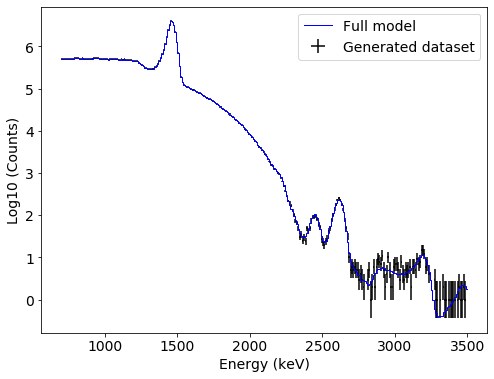

In [13]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots (1, 1, figsize=(8, 6))

hl.plot1d(ax, initial_model.project([1]).log10(), color=(0.,0.,1.), linewidth=1, label='Full model')
hl.plot1d(ax, fake_data.project([1]).log10(), color=(0.,0.,0.), crosses=True, label='Generated dataset')

plt.xlabel('Energy (keV)')
plt.ylabel('Log10 (Counts)')
plt.legend()

# Step 5: Create likelihood object

The ```nEXOFitLikelihood``` contains a model object like the one created above, and allows us to compute a Poisson-based likelihood by comparing this model to a given dataset. We'll minimize the value of this likelihood in the next step.

In [14]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()

In [15]:
# Load PDFs into the model contained in the likelihood object. This also
# executes the GenerateModelDistribution() method under the hood.

likelihood.AddPDFDataframeToModel( workspace.df_group_pdfs )
likelihood.PrintVariableList()


Variable name:            Value:
Num_Vessel_U238           1.905e+04
Num_Vessel_Th232          2.169e+03
Num_Internals_U238        4.635e+04
Num_Internals_Th232       8.667e+03
Num_FullTPC_Co60          216.2
Num_FullTPC_K40           3.257e+07
Num_Rn222                 9.107e+03
Num_FullLXeBb2n           2.795e+07
Num_FullLXeBb0n           0.0001
Num_Xe137                 46.52


Next, we can add a dataset with which we can compare this model. Since in the sensitivity calculation, the datasets are generated by sampling the model itself, this looks somewhat circular:


In [34]:
likelihood.AddDataset( likelihood.model_obj.GenerateDataset() )

Finally, to make sure it all looks the way we expect it to, let's use the model contained in ```likelihood.model_obj``` to recreate Figure 4 from the 2016 nEXO sensitivity paper.

Internals_U238: 46351.84165649111
Internals_Th232: 8667.256708537014
Vessel_U238: 19053.02605959463
Vessel_Th232: 2169.259708083749
FullTPC_K40: 32572615.748000864
Rn222: 9107.267168202485
FullLXeBb2n: 27949377.020627487
FullLXeBb0n: 0.0001
Xe137: 46.51665348579301


Text(0.5, 0, 'Standoff (mm)')

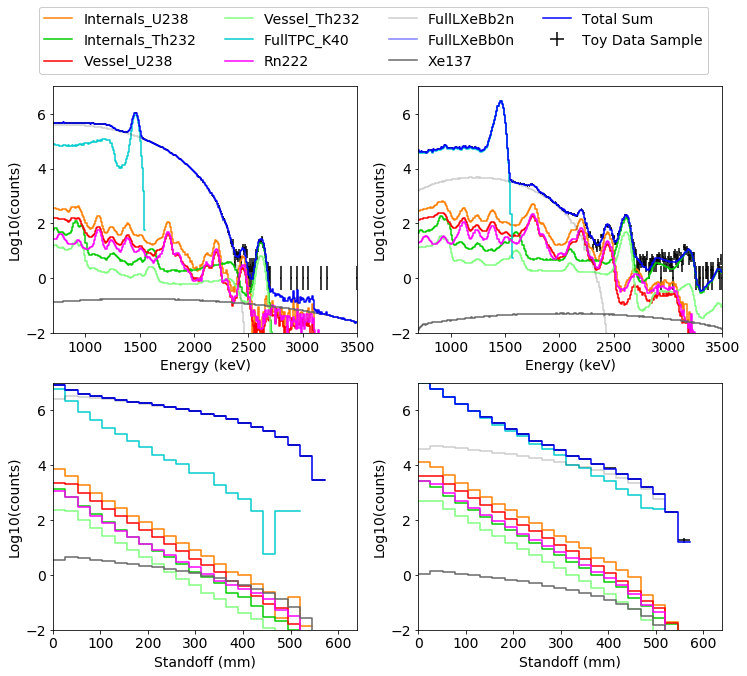

In [17]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots (2, 2, figsize=(12, 10))

newrow={}

colormap = { 'Internals_U238':(1.,0.5,0.),\
                'Internals_Th232':(0.,0.8,0.),\
                'Vessel_U238':(1.,0.,0.),\
                'Vessel_Th232':(0.5,1.,0.5),\
                'FullTPC_K40':(0.,0.8,0.8),\
                'Rn222':(1.,0.,1.),\
                'FullLXeBb2n':(0.,0.,0.,0.2),\
                'FullLXeBb0n':(0.,0.,1.,0.5),\
                'Xe137':(0.4,0.4,0.4),\
                'Total Sum':(0.,0.,1.)}

h_sum = hl.hist([np.array([0.]),np.array([0.]),np.array([0.])],bins=workspace.df_group_pdfs['Histogram'].iloc[0].bins)

# These are the SS energy histograms
for key in colormap.keys():
        if 'Total Sum' in key:
                continue
        else:
                weight_list = [thisvar['Value'] for thisvar in likelihood.model_obj.variable_list if key in thisvar['Name']]
                if len(weight_list) == 0:
                    continue
                else:
                    weight = weight_list[0]
                print('{}: {}'.format(key,weight))
                h_sum += ( weight * workspace.df_group_pdfs['Histogram'].loc[workspace.df_group_pdfs['Group']==key].iloc[0] )
                hl.plot1d(ax[0,0],\
                        ( weight * workspace.df_group_pdfs['Histogram'].loc[workspace.df_group_pdfs['Group']==key] ).iloc[0][0:1].project([1]).log10() ,\
                        color=colormap[key],label=key)
                hl.plot1d(ax[0,1],\
                        ( weight * workspace.df_group_pdfs['Histogram'].loc[workspace.df_group_pdfs['Group']==key] ).iloc[0][1:].project([1]).log10() ,\
                        color=colormap[key])
                hl.plot1d(ax[1,1],\
                        ( weight * workspace.df_group_pdfs['Histogram'].loc[workspace.df_group_pdfs['Group']==key] ).iloc[0][1:].project([2]).log10() ,\
                        color=colormap[key])
                hl.plot1d(ax[1,0],\
                        ( weight * workspace.df_group_pdfs['Histogram'].loc[workspace.df_group_pdfs['Group']==key] ).iloc[0][0:1].project([2]).log10() ,\
                        color=colormap[key])

hl.plot1d(ax[0,0],h_sum[0:1].project([1]).log10(),color=colormap['Total Sum'],label='Total Sum')
hl.plot1d(ax[0,1],h_sum[1:].project([1]).log10(),color=colormap['Total Sum'])
hl.plot1d(ax[1,1],h_sum[1:].project([2]).log10(),color=colormap['Total Sum'])
hl.plot1d(ax[1,0],h_sum[0:1].project([2]).log10(),color=colormap['Total Sum'])

hl.plot1d(ax[0,0],(likelihood.dataset[0:1]).project([1]).log10(),crosses=True,label='Toy Data Sample',color='k')
hl.plot1d(ax[0,1],(likelihood.dataset[1:]).project([1]).log10(),crosses=True,color='k')
hl.plot1d(ax[1,1],(likelihood.dataset[1:]).project([2]).log10(),crosses=True,color='k')
hl.plot1d(ax[1,0],(likelihood.dataset[0:1]).project([2]).log10(),crosses=True,color='k')

fig.legend(ncol=4,facecolor=(1.,1.,1.),framealpha=1.,loc='upper center')

ax[0,0].set_ylim(-2.,7.)
ax[0,0].set_xlim(700.,3500.)
ax[0,0].set_ylabel('Log10(counts)')
ax[0,0].set_xlabel('Energy (keV)')
ax[0,1].set_ylim(-2.,7.)
ax[0,1].set_xlim(700.,3500.)
ax[0,1].set_ylabel('Log10(counts)')
ax[0,1].set_xlabel('Energy (keV)')
ax[1,1].set_ylim(-2.,7.)
ax[1,1].set_xlim(0.,640.)
ax[1,1].set_ylabel('Log10(counts)')
ax[1,1].set_xlabel('Standoff (mm)')
ax[1,0].set_ylim(-2.,7.)
ax[1,0].set_xlim(0.,640.)
ax[1,0].set_ylabel('Log10(counts)')
ax[1,0].set_xlabel('Standoff (mm)')


On the left is the single-site (SS) distribution, and on the right is the multi-site (MS) distribution. 

Just for fun, we can also access variables by index in the ```variable_list```. This will become useful later in the fitting routine.

In [19]:

bb0n_index = likelihood.GetVariableIndex( 'Num_FullLXeBb0n' )

print('Which variable is Num_FullLXeBb0n? {}'.format(bb0n_index))

print(likelihood.variable_list[bb0n_index]['Name'])


Which variable is Num_FullLXeBb0n? 8
Num_FullLXeBb0n


# Step 6: Running a fit

To fit, I use the ```iminuit``` package (see https://iminuit.readthedocs.io/en/latest/ for more information). This is the same minimizer that RooFit uses, so we should get consistent results. 

In [35]:
from iminuit import Minuit

In [36]:
# Not sure this is necessary, but I wrap the NLL function before
# passing it to Minuit

def NegLogLikelihood(parameter_values):
    return likelihood.ComputeNegLogLikelihood(parameter_values)

In [37]:
# Also, I store the initial values in a new array outside
# of the likelihood object, so it's easy to pass to Minuit

initial_values = np.ones(len(likelihood.variable_list))

for i in range(len(likelihood.variable_list)):
    initial_values[i] = (likelihood.variable_list[i]['Value'])


The parameters for Minuit are passes as tuples, so we need to create tuples of the variable names, the step size for each parameter, and a boolean array which indicates which variables will float in the minimization.

In [40]:

# pass the names of the variables to Minuit
variable_names = tuple(var['Name'] for var in likelihood.initial_values)

# error_tuple defines the step size
error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )

# par_fix_tuple is a tuple of bools. If a value is true, then the variable
# at that index will be fixed in the minimization.
par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
par_fix_tuple = tuple( x for x in par_fix_list )


m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
m.get_param_states()

---------------------------------------------------------------------------------------------------------
|   | Name                |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------------------
| 0 | Num_Vessel_U238     |  1.79E4   |  0.04E4   |            |            |         |         |       |
| 1 | Num_Vessel_Th232    |   2050    |    40     |            |            |         |         |       |
| 2 | Num_Internals_U238  |  0.477E5  |  0.009E5  |            |            |         |         |       |
| 3 | Num_Internals_Th232 |  0.871E4  |  0.017E4  |            |            |         |         |       |
| 4 | Num_FullTPC_Co60    |    236    |     4     |            |            |         |         |       |
| 5 | Num_FullTPC_K40     |  0.326E8  |  0.007E8  |            |            |         |         |       |
| 6 | Num_Rn222           |  0.863E4  |  0.018E4  |            |            |         |         |       |
| 7 | Num_FullLXeBb2n     |  2.79E7   |  0.06E7   |            |            |         |         |       |
| 8 | Num_FullLXeBb0n     |  1.093E1  |  0.000E1  |            |            |         |         |       |
| 9 | Num_Xe137           |   91.7    |    0.9    |            |            |         |         |       |
---------------------------------------------------------------------------------------------------------

Above you see a table of the fit parameters in the Minuit object. We expect these to change once we actually run the fit. The minimizer is run using the ```migrad()``` method:

In [41]:
m.migrad()

------------------------------------------------------------------
| FCN = -7.675E+06              |     Ncalls=340 (340 total)     |
| EDM = 5.24E-05 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
|   | Name                |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------------------
| 0 | Num_Vessel_U238     |  1.962E4  |  0.000E4  |            |            |         |         |       |
| 1 | Num_Vessel_Th232    |  2508.9   |    1.4    |            |            |         |         |       |
| 2 | Num_Internals_U238  |  0.467E5  |  0.000E5  |            |            |         |         |       |
| 3 | Num_Internals_Th232 |  0.821E4  |  0.000E4  |            |            |         |         |       |
| 4 | Num_FullTPC_Co60    |   182.3   |    1.4    |            |            |         |         |       |
| 5 | Num_FullTPC_K40     |  0.326E8  |  0.000E8  |            |            |         |         |       |
| 6 | Num_Rn222           |  0.816E4  |  0.000E4  |            |            |         |         |       |
| 7 | Num_FullLXeBb2n     |  2.794E7  |  0.000E7  |            |            |         |         |       |
| 8 | Num_FullLXeBb0n     |    6.0    |    1.4    |            |            |         |         |       |
| 9 | Num_Xe137           |   170.1   |    1.4    |            |            |         |         |       |
---------------------------------------------------------------------------------------------------------

Below are a couple of examples of how to access the useful numbers produced by the ```migrad``` minimization.

In [50]:
nll_best = m.fval

par_values_best = np.array([value for key,value in m.values.items()])

print('Best fit NLL value: {:4.4}'.format(nll_best))

print('\nFree parameters and their best fit values:')
for key, value in m.values.items():
    print('{:<25} {:4.4}'.format(key,value))

Best fit NLL value: -7.675e+06

Free parameters and their best fit values:
Num_Vessel_U238           1.962e+04
Num_Vessel_Th232          2.509e+03
Num_Internals_U238        4.67e+04
Num_Internals_Th232       8.215e+03
Num_FullTPC_Co60          182.3
Num_FullTPC_K40           3.258e+07
Num_Rn222                 8.161e+03
Num_FullLXeBb2n           2.794e+07
Num_FullLXeBb0n           5.997
Num_Xe137                 170.1


# Step 7: Compute the sensitivity of nEXO

# BEYOND THIS POINT IS UNFINISHED



In [ ]:
#

In [ ]:
num_datasets = 200
num_hypotheses = 15
xvals = np.linspace(0,28,15)
lambdas = np.zeros((num_datasets,num_hypotheses))
converged = np.ones(num_datasets,dtype=bool)


In [ ]:
import time

start = time.time()

for j in range(0,num_datasets):
    print('Running dataset {}'.format(j))
    likelihood.model_obj.UpdateVariables(initial_guess)
    likelihood.model_obj.GenerateModelDistribution()
    likelihood.AddDataset( likelihood.model_obj.GenerateDataset() )

    initial_values = np.copy(initial_guess)
    variable_names = tuple(var['Name'] for var in likelihood.initial_values)
    error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )
    par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
    #par_fix_list[-2] = True
    par_fix_tuple = tuple( x for x in par_fix_list )


    m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
    m.migrad()
    nll_best = m.fval
    if not m.get_fmin()['is_valid']:
        converged[j] = False
    
    
    for i in (range(0,num_hypotheses)):
        
        initial_values = np.copy(initial_guess)
        initial_values[-2] = float(i)*2.+0.000001
        variable_names = tuple(var['Name'] for var in likelihood.initial_values)
        error_tuple = tuple( 0.02*var['Value'] for var in likelihood.initial_values )
        par_fix_list = [ False for i in range(len(likelihood.initial_values)) ]
        par_fix_list[-2] = True
        par_fix_tuple = tuple( x for x in par_fix_list )
    

        m = Minuit.from_array_func( NegLogLikelihood, \
                            initial_values, \
                            error=error_tuple, \
                            fix=par_fix_tuple, \
                            name=variable_names, \
                            errordef = 0.5 )
        m.migrad()
        lambdas[j,i] = 2*(m.fval - nll_best)
        if not m.get_fmin()['is_valid']:
            converged[j] = False
            
print('Elapsed: {:4.4}s'.format(time.time()-start))

In [ ]:
for i in range(0,20):
    if converged[i]:
        plt.plot(xvals,lambdas[i],'-',label='Run{}'.format(i))
plt.plot(xvals,np.ones(len(xvals))*2.706,'--k')
plt.text(7.,2.9,'90% confidence threshold',fontsize=10)
plt.axis([0.,30.,0.,10.])
plt.legend(loc='upper left',fontsize=10,ncol=2,labelspacing=0.1)
plt.ylabel('Test statistic')
plt.xlabel('Number of 0nuBB counts')
print('Num converged: {}'.format(np.sum(converged)))

In [ ]:
plt.plot(xvals,lambdas[8],'-',label='Example toy experiment')
plt.plot(xvals,np.ones(len(xvals))*2.706,'--k')
plt.text(12.,2.9,'90% confidence threshold',fontsize=10)
plt.text(13.5,2.3,'(Wilks\' theorem)',fontsize=10)
plt.axis([0.,20.,0.,6.])
plt.legend(loc='upper left',fontsize=11,ncol=2,labelspacing=0.1)
plt.ylabel('Likelihood ratio test statistic')
plt.xlabel('Assumed number of 0nuBB counts')
plt.savefig('example_toy_experiment_test_statistic.png',dpi=400,bbox_inches='tight')

In [ ]:
crossings = np.zeros(20)

for i in range(0,20):
    if converged[i]:
        p = np.polyfit(xvals,lambdas[i],2.)
        crossings[i] = (-p[1] + np.sqrt( p[1]**2 - 4*(p[0])*(p[2]-2.706) ))/(2*p[0])




In [ ]:
fig,ax = plt.subplots(1,1)
hteststats = hl.hist(crossings[crossings>0.],bins=np.linspace(0,30,31))
hl.plot1d(ax,hteststats,color='r')
ax.set_ylabel('Counts (20 trials total)')
ax.set_xlabel('0nuBB counts at 90% confidence limit')
plt.savefig('example_sensitivity_distribution.png',dpi=400,bbox_inches='tight')

In [ ]:
hcdf = hl.Hist(hteststats.bins,np.cumsum(hteststats.values)/np.sum(hteststats.values))
hl.plot1d(hcdf)
plt.axis([0.,30.,0.,1.])
plt.grid()

In [ ]:
initial_model

In [ ]:
df_variables = pd.DataFrame(columns=['PDF','Value','Function'])

df_variables = df_variables.append({'PDF':'Initial Model','Value':10.,'Function': lambda pdf, norm: norm*pdf},ignore_index=True)

In [ ]:
parameter = lambda pdf,norm: norm*pdf
df_variables.head()

In [ ]:
scaledhist = df_variables['Function'].iloc[0](initial_model,20.)

hl.plot1d(initial_model.project([1]).log10(),color=(0.,0.,1.),linewidth=1)
hl.plot1d(scaledhist.project([1]).log10(),color=(1.,0.,0.),linewidth=1)
